# resnext50-panda

This notebook is an adaptation of the [PANDA 16x128x128 tiles](https://www.kaggle.com/iafoss/panda-16x128x128-tiles) and the [PANDA concat tile pooling starter](https://www.kaggle.com/iafoss/panda-concat-tile-pooling-starter-0-79-lb) notebooks from the [Prostate Cancer Grade Assessment Challenge](https://www.kaggle.com/c/prostate-cancer-grade-assessment) competition on Kaggle.

## Downloading

This is a very large dataset (around 400 GB uncompressed, about 200 GB `zip` compressed). As such, working with it requires tolerating some load times.

The notebook `getting-the-data.ipynb` steps through the process of downloading this data (you will need your own Kaggle account and Kaggle API, and you will need to accept the rules of the competition on the Kaggle website).

To speed up workspace initialization time, I keep only the raw compressed dataset saved to `/spell/datasets/raw/`, so the machine only needs to load those 200 GB at initialization time. To actually get started, you will then need to uncompress the dataset, which is done here.

Some estimated times:

* 1 hour to download the compressed dataset (200 GB of data).
* 20 minutes to start up the workspace (due to the presence of 200 GB of compressed data).
* 40 minutes to unpack the compressed data onto disk (unpacks into 400 GB of data).

In [5]:
!unzip -q /spell/datasets/raw/prostate-cancer-grade-assessment.zip -d /mnt/prostate-cancer-grade-assessment/

In [8]:
# !pip install imagecodecs

In [3]:
# !apt-get update && apt-get install ffmpeg libsm6 libxext6  -y

In [49]:
# !pip install fastai

## Preprocessing

The underlying dataset has a lot of whitespace, so we split it into tiles and pick the tiles with the largest number of non-whitespace information (throwing away the rest). Check [the source notebook](https://www.kaggle.com/iafoss/panda-16x128x128-tiles) for the source, and some helpful explanation/visualization of how this works.

In [2]:
TRAIN = '/mnt/prostate-cancer-grade-assessment/train_images/'
MASKS = '/mnt/prostate-cancer-grade-assessment/train_label_masks/'
LABELS = '/mnt/prostate-cancer-grade-assessment/train.csv'
OUT_TRAIN = '/spell/datasets/working/train.zip'
OUT_MASKS = '/spell/datasets/working/masks.zip'
sz = 128
N = 16

In [3]:
import skimage
from skimage.io import MultiImage
import zipfile
import os
from tqdm import tqdm
import numpy as np
import cv2

In [4]:
def tile(img, mask):
    result = []
    shape = img.shape
    pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz
    img = np.pad(
        img, [[pad0 // 2, pad0 - pad0 // 2], [pad1 // 2, pad1 - pad1 // 2], [0, 0]],
        mode='constant', constant_values=255
    )
    mask = np.pad(
        mask, [[pad0 // 2, pad0 - pad0 // 2], [pad1 // 2, pad1 - pad1 // 2], [0,0]],
        mode='constant', constant_values=0
    )
    img = img.reshape(img.shape[0] // sz, sz, img.shape[1] // sz, sz, 3)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, sz, sz, 3)
    mask = mask.reshape(mask.shape[0] // sz, sz, mask.shape[1] // sz, sz, 3)
    mask = mask.transpose(0, 2, 1, 3, 4).reshape(-1, sz, sz, 3)
    if len(img) < N:
        mask = np.pad(mask, [[0, N-len(img)], [0,0], [0,0], [0,0]], mode='constant', constant_values=0)
        img = np.pad(img, [[0, N-len(img)], [0,0], [0,0], [0,0]], mode='constant', constant_values=255)
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    img = img[idxs]
    mask = mask[idxs]
    for i in range(len(img)):
        result.append({'img': img[i], 'mask': mask[i], 'idx': i})
    return result

In [81]:
x_tot, x2_tot = [],[]
names = [name[:-10] for name in os.listdir(MASKS)]
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out, \
    zipfile.ZipFile(OUT_MASKS, 'w') as mask_out:
    for name in tqdm(names):
        img = MultiImage(os.path.join(TRAIN,name+'.tiff'))[-1]
        mask = MultiImage(os.path.join(MASKS,name+'_mask.tiff'))[-1]
        tiles = tile(img,mask)
        for t in tiles:
            img, mask, idx = t['img'], t['mask'], t['idx']
            x_tot.append((img / 255.0).reshape(-1, 3).mean(0))
            x2_tot.append(((img / 255.0) ** 2).reshape(-1, 3).mean(0)) 
            # if read with PIL RGB turns into BGR
            img = cv2.imencode('.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))[1]
            img_out.writestr(f'{name}_{idx}.png', img)
            mask = cv2.imencode('.png', mask[:,:,0])[1]
            mask_out.writestr(f'{name}_{idx}.png', mask)

100%|██████████| 10516/10516 [10:10<00:00, 17.23it/s]


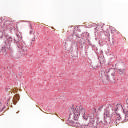

In [36]:
from IPython.display import Image

ex_img_zf = zipfile.ZipFile(OUT_TRAIN)
ex_img = ex_img_zf.open(ex_img_zf.infolist()[0].filename)
ex_img_zf.close()

Image(ex_img.read())

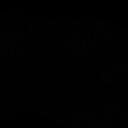

In [37]:
ex_mask_zf = zipfile.ZipFile(OUT_MASKS)
ex_mask = ex_mask_zf.open(ex_mask_zf.infolist()[0].filename)
ex_mask_zf.close()

Image(ex_mask.read())

To get this data into a run, you need to upload it as follows:

```python
# panda is a directory containing {train.csv, train.zip, masks.zip}
spell upload panda
```

This should land these files in the `panda` directory in the `uploads/` path on Spell, you can verify it worked via `spell ls uploads/` and `spell ls uploads/panda/`.

## Dataloader

The CNN takes a normalized float tensor as input, so we first need to calculate the "magic numbers" (per-channel mean value and per-channel standard deviation) that we will pass to the `torch.transforms.Normalize` function in the dataset constructor.

In [6]:
from PIL import Image
import numpy as np
import zipfile
import io

def estimate_mean_and_std(zf_path, n_samples=1000):
    def calculate_mean_and_std(img_arr):
        return np.mean(img_arr, axis=(0, 1)), np.std(img_arr, axis=(0, 1))

    all_per_channel_means = []
    all_per_channel_stds = []
    
    with zipfile.ZipFile(zf_path) as zf:
        for img_info in np.random.choice(zf.infolist(), n_samples):
            img_fn = img_info.filename
            with zf.open(img_fn) as fp:
                img = Image.open(io.BytesIO(fp.read()))
                img_arr = np.array(img)
                per_channel_means, per_channel_stds = calculate_mean_and_std(img_arr)
                all_per_channel_means.append(per_channel_means)
                all_per_channel_stds.append(per_channel_stds)
    
    estimated_channelwide_means = np.stack(all_per_channel_means).mean(axis=0)
    estimated_channelwide_stds = np.stack(all_per_channel_stds).mean(axis=0)
    return estimated_channelwide_means, estimated_channelwide_stds

In [11]:
estimate_mean_and_std(OUT_TRAIN)

(array([232.84756982, 210.74896613, 225.09535919]),
 array([26.53377176, 51.86690271, 34.32865506]))

In [12]:
tile_img_tensor_means, tile_img_tensor_stds = _

In [13]:
estimate_mean_and_std(OUT_MASKS)

(0.5094998779296875, 0.6164023965518571)

In [14]:
tile_mask_tensor_mean, tile_mask_tensor_std = _

In [89]:
with zipfile.ZipFile(OUT_TRAIN) as zf_train:
    files = [item.filename for item in zf_train.infolist()]
    files = [f[:32] for f in files]
    files = set(files)
    
    df = pd.read_csv(LABELS).set_index('image_id')
    df = df.loc[files]

10616
10516


In [90]:
import io
from PIL import Image
from torchvision import transforms
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class PandaDataset(Dataset):
    def __init__(self):
        # NOTE(aleksey): the DataFrame contains 100 entries which are mysteriously absent from
        # the train set. Here we filter these out by hand.
        with zipfile.ZipFile(OUT_TRAIN) as zf_train:
            files = [item.filename for item in zf_train.infolist()]
            files = [f[:32] for f in files]
            files = set(files)

            df = pd.read_csv(LABELS).set_index('image_id')
            df = df.loc[files]
        self.df = df.reset_index()

        self.image_zf = zipfile.ZipFile(OUT_TRAIN)
        self.mask_zf = zipfile.ZipFile(OUT_MASKS)

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        X_id = self.df.iloc[idx, 0]
        # The target variable is the isup_score, which is a value 0 through 5.
        # The moodel predicts six values per class (a la softmax).
        y = torch.tensor(self.df.iloc[idx].isup_grade)
        tile_img_tensors, tile_mask_tensors = [], []

        for tile_id in range(0, 16):
            fd = self.image_zf.open(f"{X_id}_{tile_id}.png")
            tile_img_bytes = fd.read()
            fd.close()
            
            tile_img = Image.open(io.BytesIO(tile_img_bytes))
            tile_img_arr = np.array(tile_img)
            tile_img_arr.astype(np.float)
            
            fd = self.mask_zf.open(f"{X_id}_{tile_id}.png")
            tile_mask_bytes = fd.read()
            fd.close()
            
            tile_mask = Image.open(io.BytesIO(tile_mask_bytes))
            tile_mask_arr = np.array(tile_mask)
            
            tile_img_tensor = torch.tensor(tile_img_arr, dtype=torch.float).permute(2, 0, 1)
            tile_img_tensor = transforms.Normalize(
                mean=tile_img_tensor_means, std=tile_img_tensor_stds
            )(tile_img_tensor)

            tile_mask_tensor = torch.tensor(tile_mask_arr, dtype=torch.float)[np.newaxis, ...]
            tile_mask_tensor = transforms.Normalize(
                mean=(tile_mask_tensor_mean), std=(tile_mask_tensor_std)
            )(tile_mask_tensor)
            
            tile_img_tensors.append(tile_img_tensor)
            tile_mask_tensors.append(tile_mask_tensor)
        
        return torch.cat(tile_img_tensors, dim=1), torch.cat(tile_img_tensors, dim=1), y

In [91]:
ex_dataset = PandaDataset()

In [92]:
ex_X_img, ex_X_map, ex_y = ex_dataset[0]

In [93]:
ex_X_img.shape

torch.Size([3, 2048, 128])

In [94]:
ex_X_map.shape

torch.Size([3, 2048, 128])

In [95]:
ex_y

tensor(2)

In [96]:
# spot check that the normalization was performed correctly: should be roughly (0, 1)
ex_X_img.mean(), ex_X_img.std(), ex_X_map.mean(), ex_X_map.std()

(tensor(0.3591), tensor(0.7702), tensor(0.3591), tensor(0.7702))

In [97]:
ex_dataset = PandaDataset()
ex_dataloader = DataLoader(ex_dataset, batch_size=4)

In [98]:
ex_X_img_batch, ex_X_map_batch, ex_y_batch = next(iter(ex_dataloader))

In [99]:
ex_X_img_batch.shape

torch.Size([4, 3, 2048, 128])

In [100]:
ex_X_map_batch.shape

torch.Size([4, 3, 2048, 128])

In [101]:
ex_y_batch

tensor([2, 1, 5, 2])

## Model

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from fastai.layers import AdaptiveConcatPool2d, Flatten

# The model uses a Mish() module as part of its architecture. In the original Kaggle kernel this
# is sourced from the mish_activation package. I could not determine the origin of this module,
# but inspecting the module in a Kaggle notebook (via import mish_activation; mish_activation??)
# reveals that the activation definition is a simple flat file. I've gone ahead and copied that in
# here.
class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)

class Model(nn.Module):
    def __init__(self, arch='resnext50_32x4d_ssl', n=6, pre=True):
        super().__init__()
        m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', arch)
        self.enc = nn.Sequential(*list(m.children())[:-2])
        nc = list(m.children())[-1].in_features
        self.head = nn.Sequential(
            # TODO: these are fastaia layers. I'd like to replace these with their native PyTorch
            # equivalents, but I still need to figure out how to do that.
            AdaptiveConcatPool2d(),
            Flatten(),
            nn.Linear(2 * nc, 512),
            Mish(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, n)
        )
        
    def forward(self, *x):
        shape = x[0].shape
        n = len(x)
        x = torch.stack(x, 1).view(-1, shape[1], shape[2], shape[3])
        
        #x: bs*N x 3 x 128 x 128
        x = self.enc(x)
        
        #x: bs*N x C x 4 x 4
        shape = x.shape
        #concatenate the output for tiles into a single map
        x = (x.view(-1, n, shape[1], shape[2], shape[3])
             .permute(0, 2, 1, 3, 4)
             .contiguous()
             .view(-1, shape[1], shape[2] * n, shape[3]))

        #x: bs x C x N*4 x 4
        x = self.head(x)
        #x: bs x n
        return x

In [48]:
ex_model = Model()

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [60]:
ex_model(ex_X_img_batch)

tensor([[-0.0879,  0.3679, -1.2948,  0.1353, -0.0394, -0.8638],
        [-0.9323, -0.3921,  0.0689, -1.1447, -0.0942, -1.2651],
        [ 0.0562, -0.5561,  0.9980,  0.3616, -1.2837,  2.2569],
        [ 1.4795, -0.4642,  0.1538,  0.4405,  0.5324, -0.7102]],
       grad_fn=<AddmmBackward>)

## Training loop

In [102]:
from torch import optim
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter(f'/spell/tensorboards/model_1')

NUM_EPOCHS = 1

model = Model()
model.cuda()

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
dataset = PandaDataset()
dataloader = DataLoader(dataset, batch_size=4)

for epoch in range(1, NUM_EPOCHS + 1):
    losses = []

    for i, (X, _, y) in enumerate(iter(dataloader)):
        optimizer.zero_grad()

        X = X.cuda()
        y = y.cuda()

        X_pred = model(X)
        loss = criterion(X_pred, y)
        loss.backward()
        optimizer.step()

        curr_loss = loss.item()
        if i % 10 == 0:
            print(
                f'Finished epoch {epoch}, batch {i}. Loss: {curr_loss:.3f}.'
            )

        # writer.add_scalar(
        #     'training loss', curr_loss, epoch * len(dataloader) + i
        # )
        losses.append(curr_loss)

    print(
        f'Finished epoch {epoch}. '
        f'avg loss: {np.mean(losses)}; median loss: {np.min(losses)}'
    )
    if not os.path.exists('/spell/checkpoints/'):
        os.mkdir('/spell/checkpoints/')
    torch.save(model.state_dict(), f'/spell/checkpoints/model_{epoch}.pth')

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


Finished epoch 1, batch 0. Loss: 1.888.
Finished epoch 1, batch 10. Loss: 2.396.
Finished epoch 1, batch 20. Loss: 2.331.
Finished epoch 1, batch 30. Loss: 2.202.
Finished epoch 1, batch 40. Loss: 1.977.
Finished epoch 1, batch 50. Loss: 1.372.
Finished epoch 1, batch 60. Loss: 2.526.
Finished epoch 1, batch 70. Loss: 2.161.
Finished epoch 1, batch 80. Loss: 1.811.
Finished epoch 1, batch 90. Loss: 2.358.
Finished epoch 1, batch 100. Loss: 1.949.
Finished epoch 1, batch 110. Loss: 1.752.
Finished epoch 1, batch 120. Loss: 1.425.
Finished epoch 1, batch 130. Loss: 1.983.
Finished epoch 1, batch 140. Loss: 1.634.
Finished epoch 1, batch 150. Loss: 2.234.
Finished epoch 1, batch 160. Loss: 1.184.
Finished epoch 1, batch 170. Loss: 1.147.
Finished epoch 1, batch 180. Loss: 1.660.
Finished epoch 1, batch 190. Loss: 2.502.
Finished epoch 1, batch 200. Loss: 1.882.
Finished epoch 1, batch 210. Loss: 1.500.
Finished epoch 1, batch 220. Loss: 1.877.
Finished epoch 1, batch 230. Loss: 1.609.
Fin

KeyboardInterrupt: 

In [103]:
!mkdir ../models/

In [21]:
# import pandas as pd
# test_df = pd.DataFrame({'a': [1, 2, 3], 'b': [4, 5, 6]})
# test_df_1 = test_df.sample(3 // 2)
# test_df.loc[test_df.index.difference(test_df_1.index)]

In [34]:
%%writefile ../models/model_1.py
"""
Initial model definition.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.tensorboard import SummaryWriter

from fastai.layers import AdaptiveConcatPool2d, Flatten
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import numpy as np
import pandas as pd
from PIL import Image

import os
import io
import zipfile


LABELS = '/mnt/prostate-cancer-grade-assessment/train.csv'
OUT_TRAIN = '/mnt/prostate-cancer-grade-assessment/train.zip'
OUT_MASKS = '/mnt/prostate-cancer-grade-assessment/masks.zip'
NUM_EPOCHS = 16
BATCH_SIZE = 16
TRAIN_TEST_SPLIT = 0.8


##############
# DATALOADER #
##############

def get_train_test_split():
    # NOTE(aleksey): the DataFrame contains 100 entries which are mysteriously absent from
    # the train set. Here we filter these out here.
    with zipfile.ZipFile(OUT_TRAIN) as zf_train:
        files = [item.filename for item in zf_train.infolist()]
        files = [f[:32] for f in files]
        files = set(files)

        df = pd.read_csv(LABELS).set_index('image_id')
        df = df.loc[files]
    df = df.reset_index()
    train_df = df.sample(round(len(df) * TRAIN_TEST_SPLIT))
    test_df = df.loc[df.index.difference(train_df.index)]
    return train_df, test_df


class PandaDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.image_zf = zipfile.ZipFile(OUT_TRAIN)
        self.mask_zf = zipfile.ZipFile(OUT_MASKS)

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        X_id = self.df.iloc[idx, 0]
        # The target variable is the isup_score, which is a value 0 through 5.
        # The moodel predicts six values per class (a la softmax).
        y = torch.tensor(self.df.iloc[idx].isup_grade)
        tile_img_tensors, tile_mask_tensors = [], []

        for tile_id in range(0, 16):
            fd = self.image_zf.open(f"{X_id}_{tile_id}.png")
            tile_img_bytes = fd.read()
            fd.close()
            
            tile_img = Image.open(io.BytesIO(tile_img_bytes))
            tile_img_arr = np.array(tile_img)
            tile_img_arr.astype(np.float)
            
            fd = self.mask_zf.open(f"{X_id}_{tile_id}.png")
            tile_mask_bytes = fd.read()
            fd.close()
            
            tile_mask = Image.open(io.BytesIO(tile_mask_bytes))
            tile_mask_arr = np.array(tile_mask)
            
            tile_img_tensor = torch.tensor(tile_img_arr, dtype=torch.float).permute(2, 0, 1)
            tile_img_tensor = transforms.Normalize(
                mean=tile_img_tensor_means, std=tile_img_tensor_stds
            )(tile_img_tensor)

            tile_mask_tensor = torch.tensor(tile_mask_arr, dtype=torch.float)[np.newaxis, ...]
            tile_mask_tensor = transforms.Normalize(
                mean=(tile_mask_tensor_mean), std=(tile_mask_tensor_std)
            )(tile_mask_tensor)
            
            tile_img_tensors.append(tile_img_tensor)
            tile_mask_tensors.append(tile_mask_tensor)
        
        return torch.cat(tile_img_tensors, dim=1), torch.cat(tile_img_tensors, dim=1), y


#########
# MODEL #
#########

# NOTE(aleksey): these magic values are used by torchvision.transforms.Normalize.
def estimate_mean_and_std(zf_path, n_samples=1000):
    def calculate_mean_and_std(img_arr):
        return np.mean(img_arr, axis=(0, 1)), np.std(img_arr, axis=(0, 1))

    all_per_channel_means = []
    all_per_channel_stds = []
    
    with zipfile.ZipFile(zf_path) as zf:
        for img_info in np.random.choice(zf.infolist(), n_samples):
            img_fn = img_info.filename
            with zf.open(img_fn) as fp:
                img = Image.open(io.BytesIO(fp.read()))
                img_arr = np.array(img)
                per_channel_means, per_channel_stds = calculate_mean_and_std(img_arr)
                all_per_channel_means.append(per_channel_means)
                all_per_channel_stds.append(per_channel_stds)
    
    estimated_channelwide_means = np.stack(all_per_channel_means).mean(axis=0)
    estimated_channelwide_stds = np.stack(all_per_channel_stds).mean(axis=0)
    return estimated_channelwide_means, estimated_channelwide_stds

tile_img_tensor_means, tile_img_tensor_stds = estimate_mean_and_std(OUT_TRAIN)
tile_mask_tensor_mean, tile_mask_tensor_std = estimate_mean_and_std(OUT_MASKS)

# NOTE(aleksey): the model uses a Mish() module as part of its architecture. In the original
# Kaggle kernel this model is sourced from the mish_activation package. I could not determine
# the origin of this module, but inspecting the module in a Kaggle notebook (via import
# mish_activation; mish_activation??) reveals that the activation definition is a simple flat
# file. I've gone ahead and copied that to here.
class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)


class PandaModel(nn.Module):
    # NOTE(aleksey): n=6 because the value we are trying to predict is an ordinal categorical
    # with 6 possible values.
    def __init__(self, arch='resnext50_32x4d_ssl', n=6, pre=True):
        super().__init__()
        m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', arch)
        self.enc = nn.Sequential(*list(m.children())[:-2])
        nc = list(m.children())[-1].in_features
        self.head = nn.Sequential(
            # TODO: replace these fastaia layers with torch ones
            AdaptiveConcatPool2d(),
            Flatten(),
            nn.Linear(2 * nc, 512),
            Mish(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, n)
        )
        
    def forward(self, *x):
        shape = x[0].shape
        n = len(x)
        x = torch.stack(x, 1).view(-1, shape[1], shape[2], shape[3])
        
        #x: bs*N x 3 x 128 x 128
        x = self.enc(x)
        
        #x: bs*N x C x 4 x 4
        shape = x.shape
        #concatenate the output for tiles into a single map
        x = (x.view(-1, n, shape[1], shape[2], shape[3])
             .permute(0, 2, 1, 3, 4)
             .contiguous()
             .view(-1, shape[1], shape[2] * n, shape[3]))

        #x: bs x C x N*4 x 4
        x = self.head(x)
        #x: bs x n
        return x


#################
# TRAINING LOOP #
#################

writer = SummaryWriter(f'/spell/tensorboards/model_1')

train_df, test_df = get_train_test_split()
train_dataset, test_dataset = PandaDataset(train_df), PandaDataset(test_df)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model = PandaModel()
model.cuda()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

for epoch in range(1, NUM_EPOCHS + 1):
    # train
    losses = []
    model.train()
    
    for i, (X, _, y) in enumerate(iter(train_dataloader)):
        optimizer.zero_grad()

        X = X.cuda()
        y = y.cuda()

        X_pred = model(X)
        loss = criterion(X_pred, y)
        loss.backward()
        optimizer.step()

        curr_loss = loss.item()
        if i % 10 == 0:
            print(
                f'Finished training epoch {epoch}, batch {i}. Loss: {curr_loss:.3f}.'
            )

        writer.add_scalar(
            'training loss', curr_loss, epoch * len(train_dataloader) + i
        )
        losses.append(curr_loss)

    print(
        f'Finished training epoch {epoch}. '
        f'avg loss: {np.mean(losses)}; median loss: {np.min(losses)}'
    )
    
    if not os.path.exists('/spell/checkpoints/'):
        os.mkdir('/spell/checkpoints/')
    torch.save(model.state_dict(), f'/spell/checkpoints/model_{epoch}.pth')
    
    # validation
    losses = []
    model.eval()
    
    with torch.no_grad():
        for i, (X, _, y) in enumerate(iter(test_dataloader)):
            X = X.cuda()
            y = y.cuda()
            
            X_pred = model(X)
            loss = criterion(X_pred, y)
            curr_loss = loss.item()
            if i % 10 == 0:
                print(
                    f'Finished eval epoch {epoch}, batch {i}. Loss: {curr_loss:.3f}.'
                )
            losses.append(curr_loss)

        print(
            f'Finished eval epoch {epoch}. '
            f'avg loss: {np.mean(losses)}; median loss: {np.min(losses)}'
        )
        writer.add_scalar(
            'mean val loss', np.mean(losses), epoch + 1
        )

Overwriting ../models/model_1.py


In [109]:
%%writefile ../.gitignore
*.zip
.ipynb_checkpoints/
*.csv

Overwriting ../.gitignore


In [108]:
# !cp /mnt/prostate-cancer-grade-assessment/train.csv /spell/datasets/working/train.csv

In [33]:
!spell run \
    --machine-type v100 \
    --github-url https://github.com/ResidentMario/resnext50-panda.git \
    --mount uploads/panda/train.zip:/mnt/prostate-cancer-grade-assessment/train.zip \
    --mount uploads/panda/masks.zip:/mnt/prostate-cancer-grade-assessment/masks.zip \
    --mount uploads/panda/train.csv:/mnt/prostate-cancer-grade-assessment/train.csv \
    --pip fastai --pip tqdm \
    --tensorboard-dir /spell/tensorboards/model_1/ \
    python models/model_1.py

💫 Casting spell #551…
✨ Stop viewing logs with ^C
^C

✨ Your run is still running remotely.
✨ Use 'spell kill 551' to terminate your run
✨ Use 'spell logs 551' to view logs again
